In [1]:
%run setup.py

Do not have acor package


# Read in data

## Read catalog data

In [2]:
stars = pd.read_excel(rootpath+'sample/samples.xlsx')
idx = (stars['ifmodelling']==1)
stars = stars.loc[idx,:].reset_index(drop=True)

modes = pd.read_excel(rootpath+'sample/modes.xlsx')

## Retrieve modelling results
with free surface correction or using forced surface correction

In [4]:
def retrieve_data_to_table(table, filepath, tcols, dcols):
    Ncol = len(tcols)
    for istar, star in table.iterrows():
        for icol in range(Ncol):
            file = filepath.format(star['KIC'])
            if not os.path.exists(file): continue
            data=ascii.read(file, delimiter=',')
            table.loc[istar, tcols[icol]] = data[dcols[icol]][1]
            table.loc[istar, 'e_'+tcols[icol]] = (data[dcols[icol]][2]-data[dcols[icol]][0])/2.
    return table

data_cols = ['star_mass', 'numax_scaling', 'radius', 'star_age', 'delta_nu_scaling', 'Dnu_freq', 'Teff', 'FeH', 'amlt', 'Yinit', 'luminosity']
table_cols = ['mass', 'numax', 'radius', 'age', 'Dnu_scaling','Dnu_freq', 'Teff', 'FeH', 'amlt', 'Yinit', 'luminosity']

# data_surf_cols = ['surface_a3', 'surface_correction', 'density', 'Dnu (freq)']
# table_surf_cols = ['surface_a3', 'surface_correction', 'density', 'Dnu_freq']

# data_nsurf_cols = ['surface_a3', 'surface_correction']
# table_nsurf_cols = ['surface_a3_neg', 'surface_correction_neg']


data_col_names = data_cols
table_col_names = [t+'_cubic' for t in table_cols]
filepath = rootpath+'hpc/results_cubic/{:09.0f}/summary_prob.txt'
stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)

data_col_names = data_cols
table_col_names = [t+'_cubic_linear' for t in table_cols]
filepath = rootpath+'hpc/results_sc_cubic_linear/{:09.0f}/summary_prob.txt'
stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)

data_col_names = data_cols
table_col_names = [t+'_combined' for t in table_cols]
filepath = rootpath+'hpc/results_combined/{:09.0f}/summary_prob.txt'
stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)

data_col_names = data_cols
table_col_names = [t+'_combined_linear' for t in table_cols]
filepath = rootpath+'hpc/results_sc_combined_linear/{:09.0f}/summary_prob.txt'
stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)


for suffix in ['_cubic', '_cubic_linear', '_combined', '_combined_linear']: #, '_combined_linear']: #
    gval = 'g'+suffix
    dval = 'density'+suffix
    mval = 'mass'+suffix
    rval = 'radius'+suffix
    e_gval = 'e_g'+suffix
    e_dval = 'e_density'+suffix
    e_mval = 'e_mass'+suffix
    e_rval = 'e_radius'+suffix
    stars[gval] = stars[mval]/stars[rval]**2.
    stars[e_gval] = ((stars[e_mval]/stars[mval])**2.0 \
                      + (2*stars[e_rval]/stars[rval])**2.0)**0.5 * stars[gval]
    stars[dval] = stars[mval]/stars[rval]**3.
    stars[e_dval] = ((stars[e_mval]/stars[mval])**2.0 \
                      + (3*stars[e_rval]/stars[rval])**2.0)**0.5 * stars[dval]

# HR diagram

The cluster CMD having spread in Teff is partially due to differential reddening: https://www.aanda.org/articles/aa/pdf/2012/07/aa19196-12.pdf

Text(0, 0.5, 'numax [muHz]')

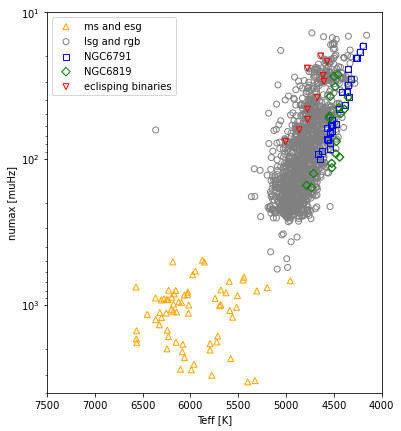

In [8]:
idx1 = np.isin(stars['stage'],['ms','esg',])
idx2 = np.isin(stars['stage'],['lsg','rgb'])
idx3 = np.isin(stars['names'],['ngc6791'])
idx4 = np.isin(stars['names'],['ngc6819'])
idx5 = np.isin(stars['names'],['binary',])

plt.figure(figsize=[6,7])
plt.scatter(stars.loc[idx1,'Teff'], stars.loc[idx1,'numax'], marker='^', facecolor='none', edgecolor='orange', label='ms and esg')
plt.scatter(stars.loc[idx2,'Teff'], stars.loc[idx2,'numax'], marker='o', facecolor='none', edgecolor='gray', label='lsg and rgb')
plt.scatter(stars.loc[idx3,'Teff'], stars.loc[idx3,'numax'], marker='s', facecolor='none', edgecolor='blue', label='NGC6791')
plt.scatter(stars.loc[idx4,'Teff'], stars.loc[idx4,'numax'], marker='D', facecolor='none', edgecolor='green', label='NGC6819')
plt.scatter(stars.loc[idx5,'Teff'], stars.loc[idx5,'numax'], marker='v', facecolor='none', edgecolor='red', label='eclisping binaries')
plt.xlim(7500,4000)
plt.ylim(4000,10)
plt.yscale('log')
plt.legend()
plt.xlabel('Teff [K]')
plt.ylabel('numax [muHz]')

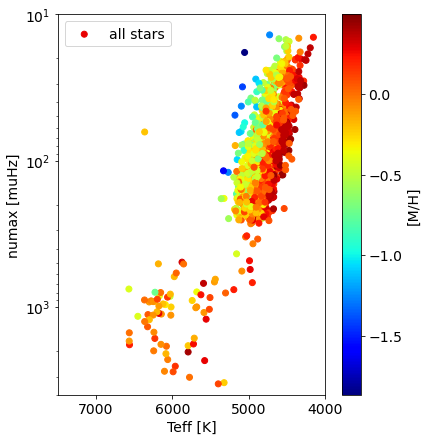

In [32]:
plt.figure(figsize=[6,7])
idx = stars['KIC']>-1
plt.scatter(stars.loc[idx,'Teff'], stars.loc[idx,'numax'], marker='o', c=stars.loc[idx,'[M/H]'], cmap='jet', label='all stars')
plt.xlim(7500,4000)
plt.ylim(4000,10)
plt.yscale('log')
plt.legend()
plt.xlabel('Teff [K]')
plt.ylabel('numax [muHz]')
plt.colorbar().set_label('[M/H]')

# stellar model parameter difference between freeSC and fixSC

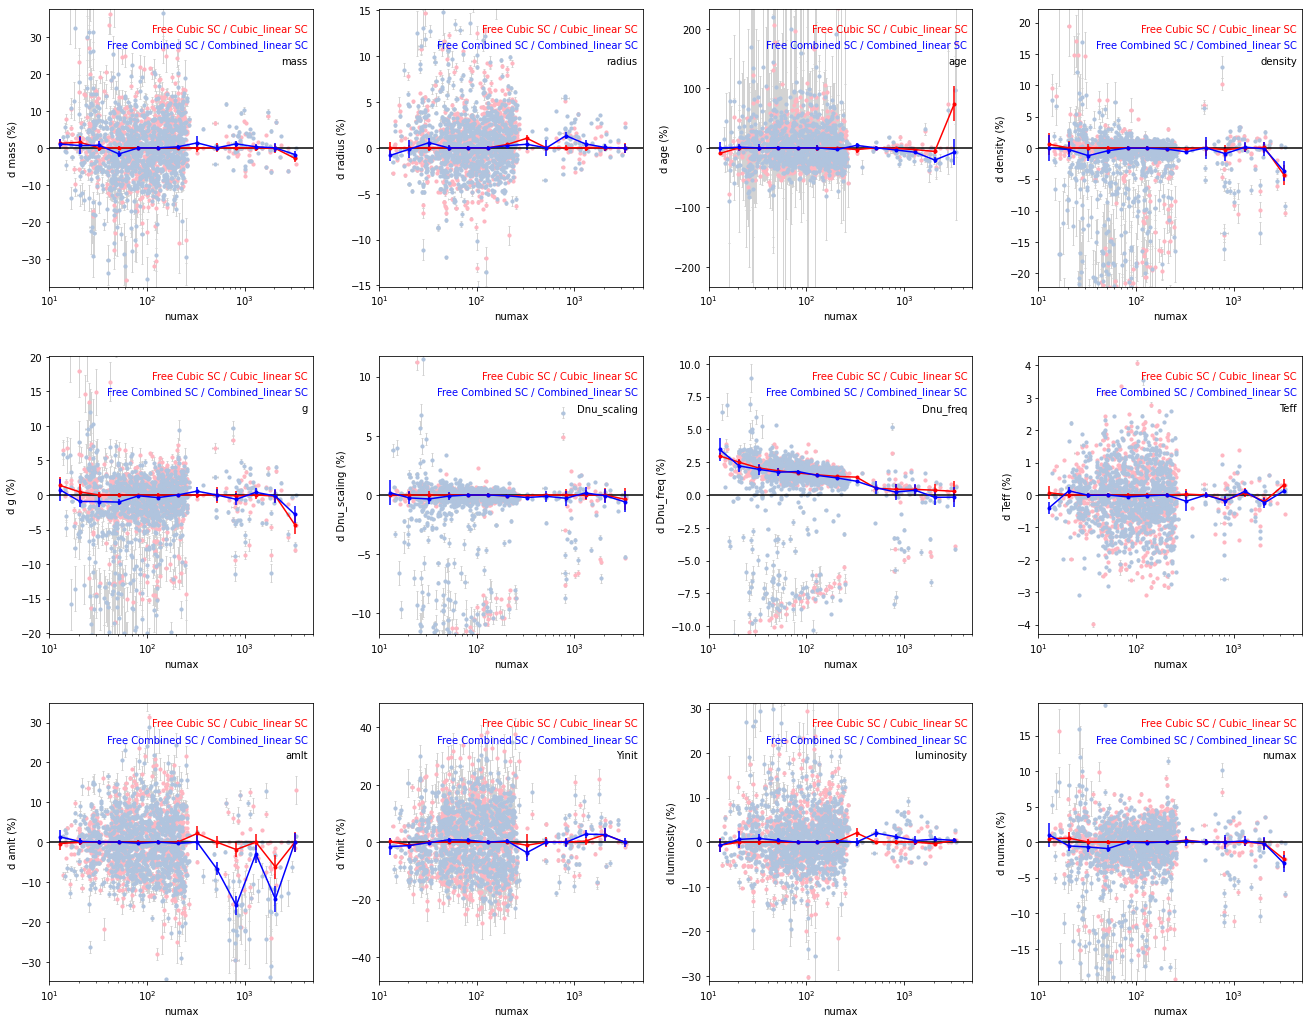

In [13]:
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-0.5,vmax=0.5)

gridspec_kw = {'left':0.07, 'right':0.94, 'top':0.96, 'bottom':0.06, 'wspace':0.25, 'hspace':0.25}
fig, axes = plt.subplots(figsize=(20,15), nrows=3, ncols=4, squeeze=False, gridspec_kw=gridspec_kw)
axes = axes.reshape(-1)

# idx = ((stars['numax']>0) & (stars['ALPHA_M']<0.05) & (stars['ALPHA_M']>-0.05)) |(stars['names']=='Sun') # & np.isfinite(stars['DPi1_V16'])
# sample = stars.loc[idx,:]
idx = np.isfinite(stars['mass_cubic']) & np.isfinite(stars['mass_cubic_linear']) 

sample = stars.loc[idx,:]

errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}

var = ['mass', 'radius', 'age', 'density', 'g', 'Dnu_scaling', 'Dnu_freq', 'Teff', 'amlt', 'Yinit', 'luminosity', 'numax']


for iax, ax in enumerate(axes[:]):
    v1 = var[iax]+'_cubic'
    ev1 = 'e_'+var[iax]+'_cubic'

    v2 = var[iax]+'_cubic_linear'
    ev2 = 'e_'+var[iax]+'_cubic_linear'
    
    
    v3 = var[iax]+'_combined'
    ev3 = 'e_'+var[iax]+'_combined'

    v4 = var[iax]+'_combined_linear'
    ev4 = 'e_'+var[iax]+'_combined_linear'

    
    x = sample.loc[:,'numax']
    y1 = (sample.loc[:,v1]/sample.loc[:,v2]-1)*100
    y2 = (sample.loc[:,v3]/sample.loc[:,v4]-1)*100
    
    ex = sample.loc[:,'e_numax']
    ey1 = y1*((sample.loc[:,ev1]/sample.loc[:,v1])**2.0 + (sample.loc[:,ev2]/sample.loc[:,v2])**2.0)**0.5
    ey2 = y2*((sample.loc[:,ev3]/sample.loc[:,v4])**2.0 + (sample.loc[:,ev3]/sample.loc[:,v3])**2.0)**0.5
    
    idx = np.isfinite(x) & np.isfinite(y1) & np.isfinite(ex) & np.isfinite(ey1) & np.isfinite(y2) & np.isfinite(ey2)
    x,y1,ex,ey1 = x[idx],y1[idx],ex[idx],ey1[idx]
    y2,ey2 = y2[idx],ey2[idx]
    
    xcs1, medians1, stds1 = se.get_binned_median(x, y1, np.logspace(np.log(10), np.log(4000), 14, base=np.e))
    xcs2, medians2, stds2 = se.get_binned_median(x, y2, np.logspace(np.log(10), np.log(4000), 14, base=np.e))
    
    ax.scatter(x, y1, color='lightpink', marker='o', s=10)
    ax.scatter(x, y2, color='lightsteelblue', marker='o', s=10)
    ax.errorbar(x, y1, xerr=ex, yerr=ey1, **errorstyle)
    ax.errorbar(x, y2, xerr=ex, yerr=ey2, **errorstyle)
    ax.errorbar(xcs1, medians1, yerr=stds1, fmt='r.-')
    ax.errorbar(xcs2, medians2, yerr=stds2, fmt='b.-')
    
    ax.set_xlim(10, 5000)
    ax.set_ylim(-np.std(y1)*5, np.std(y1)*5)
    ax.set_xlabel('numax')
    ax.set_xscale('log')
    ax.axhline(0., linestyle='-', color='k')
    ax.set_ylabel('d {:s} (%)'.format(var[iax]))
    ax.text(0.98, 0.95, 'Free Cubic SC / Cubic_linear SC', transform=ax.transAxes, ha='right', va='top', color='r')
    ax.text(0.98, 0.89, 'Free Combined SC / Combined_linear SC', transform=ax.transAxes, ha='right', va='top', color='b')
    ax.text(0.98, 0.83, var[iax], transform=ax.transAxes, ha='right', va='top', color='k')

# stellar model parameter error difference between freeSC and fixSC
## Cubic
The errors bars on a similar magnitude - which is good.

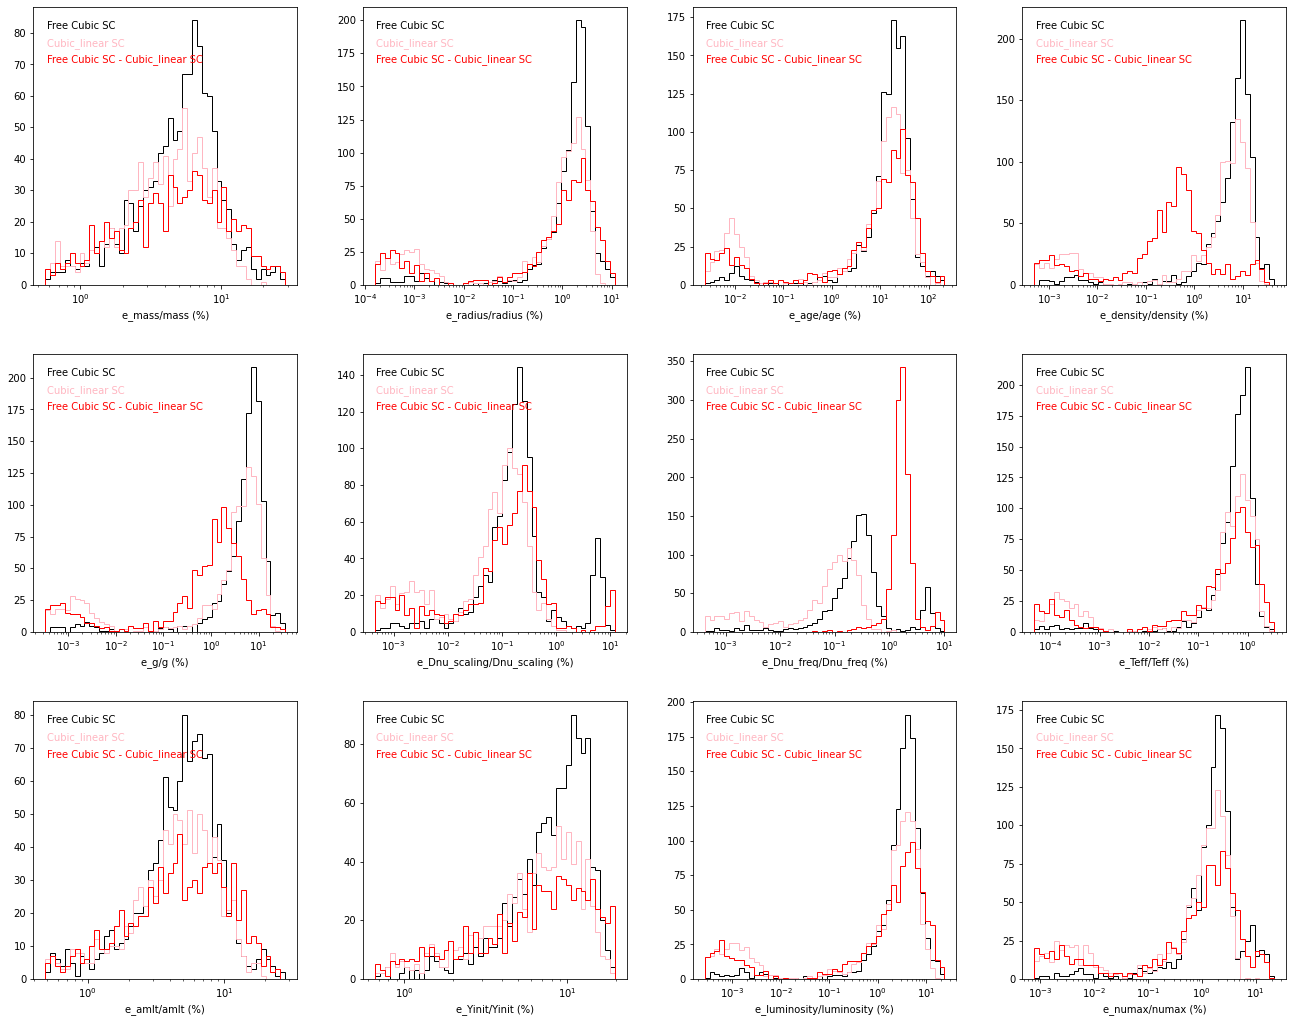

In [14]:
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-0.5,vmax=0.5)

gridspec_kw = {'left':0.07, 'right':0.94, 'top':0.96, 'bottom':0.06, 'wspace':0.25, 'hspace':0.25}
fig, axes = plt.subplots(figsize=(20,15), nrows=3, ncols=4, squeeze=False, gridspec_kw=gridspec_kw)
axes = axes.reshape(-1)

# idx = ((stars['numax']>0) & (stars['ALPHA_M']<0.05) & (stars['ALPHA_M']>-0.05)) |(stars['names']=='Sun') # & np.isfinite(stars['DPi1_V16'])
# sample = stars.loc[idx,:]
idx = np.isfinite(stars['mass_cubic']) & np.isfinite(stars['mass_cubic_linear']) 

sample = stars.loc[idx,:]

errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}

var = ['mass', 'radius', 'age', 'density', 'g', 'Dnu_scaling', 'Dnu_freq', 'Teff', 'amlt', 'Yinit', 'luminosity', 'numax']


for iax, ax in enumerate(axes[:]):
    v1 = var[iax]+'_cubic'
    ev1 = 'e_'+var[iax]+'_cubic'

    v2 = var[iax]+'_cubic_linear'
    ev2 = 'e_'+var[iax]+'_cubic_linear'
    
    x = np.array(sample.loc[:,v1])
    ex = np.array(sample.loc[:,ev1])
    y = np.array(sample.loc[:,v2])
    ey = np.array(sample.loc[:,ev2])
    rex, rey = ex/x*100, ey/y*100
    
    rdxy = np.abs(x/y-1)*100
    
    idx = np.isfinite(rex) & np.isfinite(rey)
    rex,rey = rex[idx],rey[idx]

    bins = np.logspace(np.log10(min(np.percentile(rex[rex>0],5), np.percentile(rey[rey>0],5)   )), #,np.percentile(rez[rez>0],5)
                       np.log10(max(np.percentile(rex,99.9), np.percentile(rey,99.9)  )), 50) #, np.percentile(rez,99.9)
    histtype={'bins':bins, 'histtype':'step'}
    ax.hist(rex, color='k', **histtype)
    ax.hist(rey, color='lightpink', **histtype)
    ax.hist(rdxy, color='red', **histtype)
    
    ax.set_xscale('log')
    ax.set_xlabel('e_'+var[iax]+'/'+var[iax]+' (%)')
    
    ax.text(0.05, 0.95, 'Free Cubic SC', transform=ax.transAxes, ha='left', va='top', color='k')
    ax.text(0.05, 0.89, 'Cubic_linear SC', transform=ax.transAxes, ha='left', va='top', color='lightpink')
    ax.text(0.05, 0.83, 'Free Cubic SC - Cubic_linear SC', transform=ax.transAxes, ha='left', va='top', color='red')

## Combined

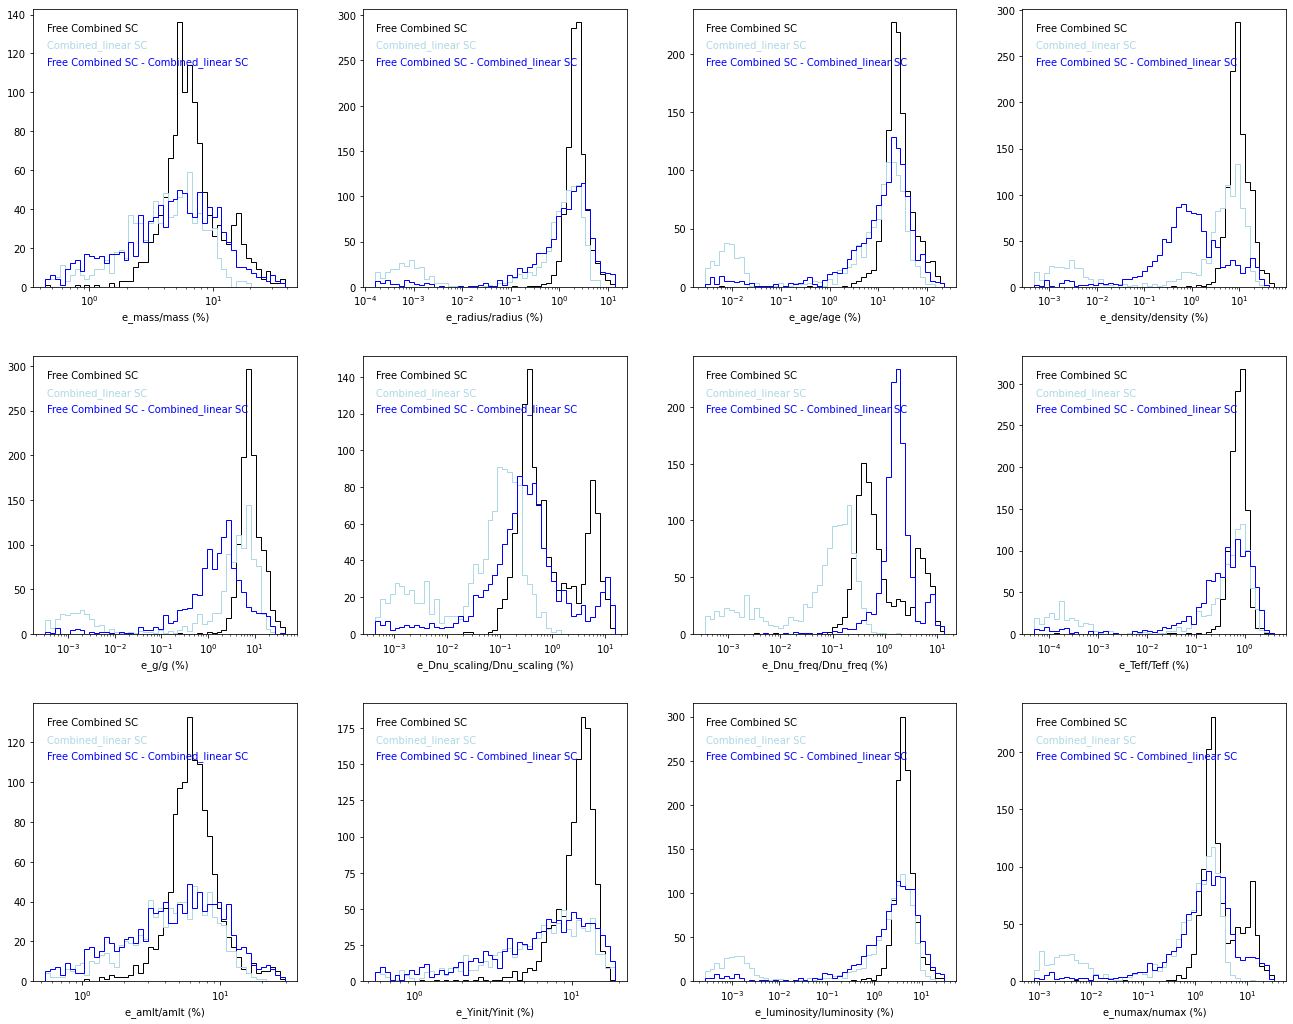

In [16]:
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-0.5,vmax=0.5)

gridspec_kw = {'left':0.07, 'right':0.94, 'top':0.96, 'bottom':0.06, 'wspace':0.25, 'hspace':0.25}
fig, axes = plt.subplots(figsize=(20,15), nrows=3, ncols=4, squeeze=False, gridspec_kw=gridspec_kw)
axes = axes.reshape(-1)

# idx = ((stars['numax']>0) & (stars['ALPHA_M']<0.05) & (stars['ALPHA_M']>-0.05)) |(stars['names']=='Sun') # & np.isfinite(stars['DPi1_V16'])
# sample = stars.loc[idx,:]
idx = np.isfinite(stars['mass_combined']) & np.isfinite(stars['mass_combined_linear']) 

sample = stars.loc[idx,:]

errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}

var = ['mass', 'radius', 'age', 'density', 'g', 'Dnu_scaling', 'Dnu_freq', 'Teff', 'amlt', 'Yinit', 'luminosity', 'numax']


for iax, ax in enumerate(axes[:]):
    v1 = var[iax]+'_combined'
    ev1 = 'e_'+var[iax]+'_combined'

    v2 = var[iax]+'_combined_linear'
    ev2 = 'e_'+var[iax]+'_combined_linear'
    
    x = np.array(sample.loc[:,v1])
    ex = np.array(sample.loc[:,ev1])
    y = np.array(sample.loc[:,v2])
    ey = np.array(sample.loc[:,ev2])
    rex, rey = ex/x*100, ey/y*100
    
    rdxy = np.abs(x/y-1)*100
    
    idx = np.isfinite(rex) & np.isfinite(rey)
    rex,rey = rex[idx],rey[idx]

    bins = np.logspace(np.log10(min(np.percentile(rex[rex>0],5), np.percentile(rey[rey>0],5)   )), #,np.percentile(rez[rez>0],5)
                       np.log10(max(np.percentile(rex,99.9), np.percentile(rey,99.9)  )), 50) #, np.percentile(rez,99.9)
    histtype={'bins':bins, 'histtype':'step'}
    ax.hist(rex, color='k', **histtype)
    ax.hist(rey, color='lightblue', **histtype)
    ax.hist(rdxy, color='blue', **histtype)
    
    ax.set_xscale('log')
    ax.set_xlabel('e_'+var[iax]+'/'+var[iax]+' (%)')
    
    ax.text(0.05, 0.95, 'Free Combined SC', transform=ax.transAxes, ha='left', va='top', color='k')
    ax.text(0.05, 0.89, 'Combined_linear SC', transform=ax.transAxes, ha='left', va='top', color='lightblue')
    ax.text(0.05, 0.83, 'Free Combined SC - Combined_linear SC', transform=ax.transAxes, ha='left', va='top', color='blue')

# numax scaling relation (for fun)

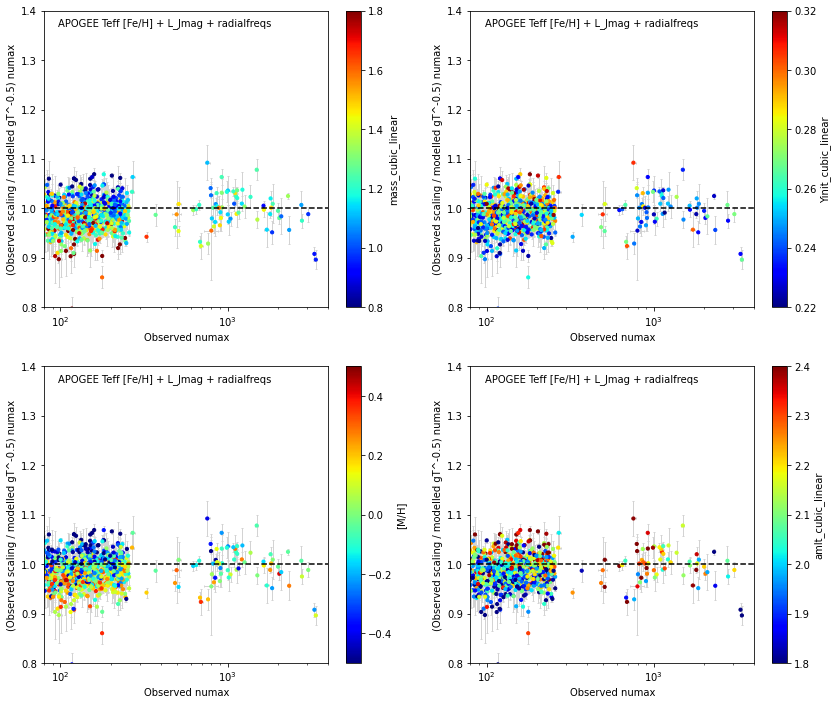

In [20]:
import matplotlib.colors
from astropy.io import ascii
# norm=matplotlib.colors.Normalize(vmin=-0.5, vmax=0.5)
norms=[matplotlib.colors.Normalize(vmin=0.8, vmax=1.8), # mass
       matplotlib.colors.Normalize(vmin=0.22, vmax=0.32), # Yinit
       matplotlib.colors.Normalize(vmin=-0.5, vmax=0.5), # feh
       matplotlib.colors.Normalize(vmin=1.8, vmax=2.4), # amlt
       matplotlib.colors.Normalize(vmin=-0.2, vmax=0.0), # surf_corr_at_numax
       matplotlib.colors.Normalize(vmin=-1*1e-5, vmax=0.00*1e-5)] # surface_a3

# suffix = '_cubic_free'
suffix = '_cubic_linear'
cvars = ['mass'+suffix, 'Yinit'+suffix, '[M/H]', 'amlt'+suffix]

vx = 'numax'
vy = 'numax'+suffix
evx = 'e_numax'
evy = 'e_numax'+suffix
    
fig, axes = plt.subplots(figsize=(14,12), nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

for iax, ax in enumerate(axes):
#     idx = ((stars['numax']>0) & (stars['ALPHA_M']<0.05) & (stars['ALPHA_M']>-0.05)) |(stars['names']=='Sun') # & np.isfinite(stars['DPi1_V16'])
    idx = stars['ifmodelling']==1
    sample = stars.loc[idx,:]
    scatterstyle= {'norm':norms[iax], 'cmap':'jet', 's':10}
    errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}
    
    c=axes[iax].scatter(sample.loc[:,vx], 
                      sample.loc[:,vx]/sample.loc[:,vy], 
               c=sample.loc[:,cvars[iax]], marker='o', **scatterstyle)

    axes[iax].errorbar(sample.loc[:,vx], 
                     sample.loc[:,vx]/sample.loc[:,vy],
                xerr = sample.loc[:, evx],
                yerr = ((sample.loc[:,evy]/sample.loc[:,vy])**2.+
                        (sample.loc[:,evx]/sample.loc[:,vx])**2.)**0.5, **errorstyle)

    sunidx = stars['stage']=='sun'
    sample = stars.loc[sunidx,:]
    scatterstyle_sun= {'norm':norms[iax], 'cmap':'jet', 's':50}
    errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}

    axes[iax].scatter(sample.loc[:,vx], 
                      sample.loc[:,vx]/sample.loc[:,vy], 
               c=sample.loc[:,cvars[iax]], marker='*', **scatterstyle_sun)

    axes[iax].errorbar(sample.loc[:,vx], 
                     sample.loc[:,vx]/sample.loc[:,vy],
                xerr = sample.loc[:, evx],
                yerr = ((sample.loc[:,evy]/sample.loc[:,vy])**2.+
                        (sample.loc[:,evx]/sample.loc[:,vx])**2.)**0.5, **errorstyle)
    
    axes[iax].plot([10,10000],[1. ,1.], 'k--')
    axes[iax].axis([80,4000,0.8,1.4 ])
    axes[iax].set_xlabel('Observed numax')
    axes[iax].set_xscale('log')
    axes[iax].set_ylabel('(Observed scaling / modelled gT^-0.5) numax')
    fig.colorbar(c, ax=axes[iax]).set_label(cvars[iax])   
    
    axes[iax].text(0.05, 0.95, 'APOGEE Teff [Fe/H] + L_Jmag + radialfreqs', transform=axes[iax].transAxes)

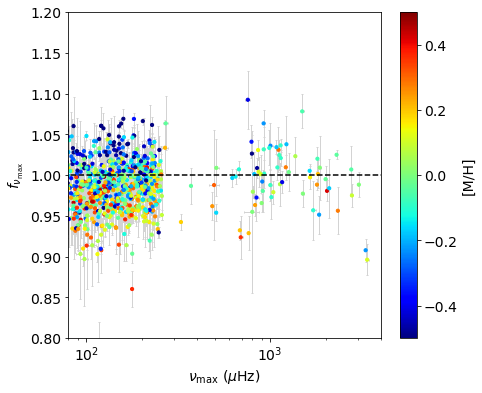

In [23]:
import matplotlib.colors
import matplotlib 
matplotlib.rcParams["font.size"] = 14. #7.5

from astropy.io import ascii
norm=matplotlib.colors.Normalize(vmin=-0.5, vmax=0.5)


# suffix = '_cubic'
suffix = '_cubic_linear'
cvars = ['[M/H]', 'amlt'+suffix]

vx = 'numax'
vy = 'numax'+suffix
evx = 'e_numax'
evy = 'e_numax'+suffix
    
fig, axes = plt.subplots(figsize=(7,6), nrows=1, ncols=1, squeeze=False)
axes = axes.reshape(-1)

for iax, ax in enumerate(axes):
#     idx = ((stars['numax']>0) & (stars['ALPHA_M']<0.05) & (stars['ALPHA_M']>-0.05)) |(stars['names']=='Sun') # & np.isfinite(stars['DPi1_V16'])
    idx = stars['ifmodelling']==1
    sample = stars.loc[idx,:]
    scatterstyle= {'norm':norm, 'cmap':'jet', 's':10}
    errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}
    
    c=axes[iax].scatter(sample.loc[:,vx], 
                      sample.loc[:,vx]/sample.loc[:,vy], 
               c=sample.loc[:,cvars[iax]], marker='o', **scatterstyle)

    axes[iax].errorbar(sample.loc[:,vx], 
                     sample.loc[:,vx]/sample.loc[:,vy],
                xerr = sample.loc[:, evx],
                yerr = ((sample.loc[:,evy]/sample.loc[:,vy])**2.+
                        (sample.loc[:,evx]/sample.loc[:,vx])**2.)**0.5, **errorstyle)

    sunidx = stars['stage']=='sun'
    sample = stars.loc[sunidx,:]
    scatterstyle_sun= {'norm':norm, 'cmap':'jet', 's':50}
    errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}

    axes[iax].scatter(sample.loc[:,vx], 
                      sample.loc[:,vx]/sample.loc[:,vy], 
               c=sample.loc[:,cvars[iax]], marker='*', **scatterstyle_sun)

    axes[iax].errorbar(sample.loc[:,vx], 
                     sample.loc[:,vx]/sample.loc[:,vy],
                xerr = sample.loc[:, evx],
                yerr = ((sample.loc[:,evy]/sample.loc[:,vy])**2.+
                        (sample.loc[:,evx]/sample.loc[:,vx])**2.)**0.5, **errorstyle)
    
    axes[iax].plot([10,10000],[1. ,1.], 'k--')
    axes[iax].axis([80,4000,0.8,1.2 ])
    axes[iax].set_xlabel('$\\nu_{\\rm max}$ ($\\mu$Hz)')
    axes[iax].set_xscale('log')
    axes[iax].set_ylabel('$f_{\\nu_{\\rm max}}$')
    fig.colorbar(c, ax=axes[iax]).set_label('[M/H]')   


[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float

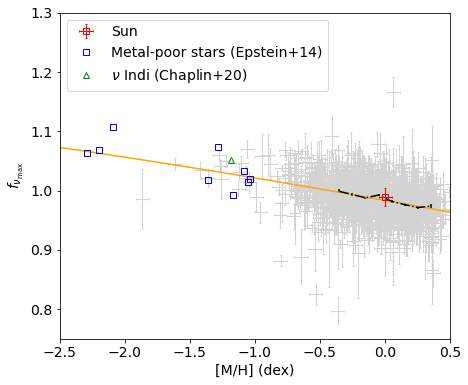

In [27]:
import matplotlib.colors
import matplotlib 
matplotlib.rcParams["font.size"] = 14. #7.5

from astropy.io import ascii
norm=matplotlib.colors.Normalize(vmin=-0.5, vmax=0.5)


# suffix = '_cubic_free'
suffix = '_cubic_linear'

vx = 'numax'
vy = 'numax'+suffix
evx = 'e_numax'
evy = 'e_numax'+suffix

# idx = ((stars['numax']>0) & (stars['ALPHA_M']<0.05) & (stars['ALPHA_M']>-0.05)) | (stars['names']=='Sun') # & np.isfinite(stars['DPi1_V16'])
idx = stars['ifmodelling']==1
sample = stars.loc[idx,:].reset_index(drop=True)
    
sample['fnumax'] = sample[vx]/sample[vy]
sample['e_fnumax'] = ((sample[evy]/sample[vy])**2. + (sample[evx]/sample[vx])**2.)**0.5

fig, axes = plt.subplots(figsize=(7,6), nrows=1, ncols=1, squeeze=False)
axes = axes.reshape(-1)

scatterstyle= {'norm':norm, 'cmap':'jet', 's':10}
errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}

axes[0].errorbar(sample.loc[:,'[M/H]'],sample.loc[:,'fnumax'],xerr = sample.loc[:,'e_[M/H]'],yerr = sample.loc[:,'e_fnumax'], **errorstyle)
xcs, medians, stds = se.get_binned_median(sample.loc[:,'[M/H]'],sample.loc[:,'fnumax'],np.arange(-0.4,0.41,0.1))
axes[0].errorbar(xcs, medians, yerr=stds, fmt='k-.')

# sun
sunidx = sample['KIC']==0
scatterstyle_sun= {'norm':norm, 'cmap':'jet', 's':50}
errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'red', 'linestyle':'None','marker':'s', 'mfc':'none', 'mec':'red',  'zorder':10, 'label':'Sun'}

axes[0].errorbar(sample.loc[sunidx,'[M/H]'], sample.loc[sunidx,'fnumax'], xerr = sample.loc[sunidx,'e_[M/H]'], yerr = sample.loc[sunidx,'e_fnumax'], **errorstyle)


# metal-poor stars 
from fdnu import asfgrid
numaxs = np.array([16.83, 18.59, 3.08, 41.82, 33.49, 174.41, 27.68, 31.81, 85.01])
Dnus = np.array([2.46, 2.62, 0.64, 4.95, 4.13, 14.41, 3.43, 4.03, 8.43])
Teffs = np.array([4899, 4862, 4586, 4820, 4702, 4820, 4754, 4726, 4903])
masses_scaling = (numaxs/3090)**3. * (Dnus/135.1)**-4. * (Teffs/5777)**1.5
masses_true = np.array([0.81, 0.81, 0.81, 0.82, 0.84, 0.84, 0.85, 0.85, 0.85])
mhs1 = np.array([-2.29, -2.20, -2.09, -1.36, -1.05, -1.04, -1.28, -1.17, -1.08])

s=asfgrid.Seism(datadir=rootpath+'fdnu/')
evstate = np.ones(len(Teffs))
t1mass,t2radius=s.get_mass_radius(evstate,mhs1,Teffs,Dnus,numaxs,isfeh=True)
logg=s.mr2logg(t1mass,t2radius)
_,_,fdnus = s.get_dnu_numax(evstate,mhs1,Teffs,masses_true,masses_true,logg,fill_value='nearest',isfeh=True)

fnumaxs1 = (masses_true/masses_scaling/(fdnus**4.))**(-1/3)
errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'blue', 'linestyle':'None', 
              'marker':'s', 'mfc':'none', 'mec':'blue', 'zorder':10, 'label':'Metal-poor stars (Epstein+14)'}
axes[0].errorbar(mhs1, fnumaxs1, **errorstyle)


# nu-indi
numaxs = np.array([325.])
Dnus = np.array([24.4])
Teffs = np.array([5320])
masses_scaling = (numaxs/3090)**3. * (Dnus/135.1)**-4. * (Teffs/5777)**1.5
masses_true = np.array([0.85])
mhs2 = np.array([-1.18])

s=asfgrid.Seism(datadir=rootpath+'fdnu/')
evstate = np.ones(len(Teffs))
t1mass,t2radius=s.get_mass_radius(evstate,mhs2,Teffs,Dnus,numaxs,isfeh=True)
logg=s.mr2logg(t1mass,t2radius)
_,_,fdnus = s.get_dnu_numax(evstate,mhs2,Teffs,masses_true,masses_true,logg,fill_value='nearest',isfeh=True)

fnumaxs2 = (masses_true/masses_scaling/(fdnus**4.))**(-1/3)
errorstyle = {'elinewidth':1, 'capsize':1, 'ecolor':'green', 'linestyle':'None', 
              'marker':'^', 'mfc':'none', 'mec':'green', 'zorder':10, 'label':'$\\nu$ Indi (Chaplin+20)'}
axes[0].errorbar(mhs2, fnumaxs2, **errorstyle)


axes[0].axis([-2.5,0.5,0.75,1.3])
axes[0].set_xlabel('[M/H] (dex)')
axes[0].set_ylabel('$f_{\\nu_{\\rm max}}$')
axes[0].legend()


# fit 
x = np.concatenate([sample['[M/H]'], mhs1, mhs2])
y = np.concatenate([sample['fnumax'], fnumaxs1, fnumaxs2])
idx = np.isfinite(x) & np.isfinite(y)
x, y = x[idx], y[idx]
p = np.polyfit(x, y, 2)
xp = np.linspace(-2.5, 0.5, 100)
yp = np.polyval(p, xp)
axes[0].plot(xp, yp, color='orange')

In [136]:
# np.polyval(p, 0.5)
p = np.array([-0.00718002, -0.05279003,  0.9892853 ])
np.polyval(p, -2.)

1.06614528

In [142]:
fnumax = np.polyval(p, -2.)
13/fnumax

12.193460163327835

In [123]:
# numaxs = np.array([16.83, 18.59, 3.08, 41.82, 33.49, 174.41, 27.68, 31.81, 85.01])
# Dnus = np.array([2.46, 2.62, 0.64, 4.95, 4.13, 14.41, 3.43, 4.03, 8.43])
# Teffs = np.array([4899, 4862, 4586, 4820, 4702, 4820, 4754, 4726, 4903])
# masses_scaling = (numaxs/3090)**3. * (Dnus/135.1)**-4. * (Teffs/5777)**1.5
# masses_true = np.array([0.81, 0.81, 0.81, 0.82, 0.84, 0.84, 0.85, 0.85, 0.85])
# mhs1 = np.array([-2.29, -2.20, -2.09, -1.36, -1.05, -1.04, -1.28, -1.17, -1.08])

mh = np.array([-2.5, 0.])
fnumax = np.polyval(p, mh)
nu_max = 16.*fnumax#16.83
k, b = 0.9638, -1.7145
width = np.exp(k*np.log(nu_max) + b)
freqMin = nu_max - width*5 
freqMax = nu_max + width*5
print(freqMin, freqMax)

[43.54092535 39.65582855] [300.90234615 276.91546845]


In [110]:
mhs = np.linspace(-4., -1., 10)
numaxs = np.zeros(10)+208.2
Dnus = np.zeros(10)+17.47
Teffs = np.zeros(10)+5400
masses_scaling = (numaxs/3090)**3. * (Dnus/135.1)**-4. * (Teffs/5777)**1.5
masses_true = np.zeros(10)+0.82

fnumax = np.polyval(p, mhs)

s=asfgrid.Seism(datadir=rootpath+'fdnu/')
evstate = np.ones(len(Teffs))
tmass,tradius=s.get_mass_radius(evstate,mhs,Teffs,Dnus,numaxs,isfeh=True)
tmass = tmass/fnumax**3.
tradius = tradius/fnumax
logg = np.log10(tmass/tradius**2.*27400)
dnu, numax, fdnu = s.get_dnu_numax(evstate,mhs,Teffs,masses_true,masses_true,logg,fill_value='nearest',isfeh=False)
# print(t1mass, t1mass/1.08**3., t2radius, t2radius/1.08)

[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
outside interp range 3  out of  10
outside interp range 1  out of  10


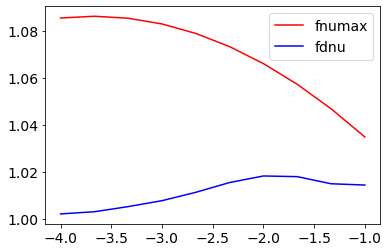

In [113]:
plt.plot(mhs, fnumax, 'r-', label='fnumax')
plt.plot(mhs, fdnu, 'b-', label='fdnu')
plt.legend()

In [108]:
fnumax

array([1.08556504, 1.08631731, 1.08547402, 1.08303517, 1.07900076,
       1.07337079, 1.06614526, 1.05732417, 1.04690752, 1.03489531])

In [105]:
s.get_mass_radius(evstate,mhs,Teffs,Dnus,numaxs,isfeh=True)

outside interp range 3  out of  10


(array([1.00899763, 1.00899763, 1.00899763, 0.99130434, 0.99277433,
        0.99424431, 0.99571429, 1.00171106, 1.00858637, 1.01965322]),
 array([3.93560135, 3.93560135, 3.93560135, 3.90094236, 3.9038336 ,
        3.9067227 , 3.90960967, 3.92136496, 3.93479922, 3.95632788]))

In [106]:
p

array([-0.00718002, -0.05279003,  0.9892853 ])